In [1]:
import time
import os
import math
import numpy as np
import cv2
import pandas as pd
import pyautogui as pa
from scipy.stats import binom_test
from matplotlib import rcParams
import datetime
from scipy.stats import norm, kstest, sem, ttest_ind
from numpy.polynomial import polynomial
import imageio

from lib.file.ROI_writer import ROIFileWriter
from lib.file.ROI_reader import ROIFileReader
from lib.analysis.cell_roi import RandomROISample
from lib.auto_GUI.auto_GUI_base import AutoGUIBase
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
from lib.file.ROI_reader import ROIFileReader
from lib.analysis.cell_roi import OverlapCounterROI
from lib.analysis.baseline_correction import BaselineCorrection

C:\Users\jjudge3\AppData\Roaming\Python\Python39\site-packages\matplotlib\projections\__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/controlled_baseline/single_pixel_analysis/"
master_csv = data_dir + 'scnn1a-ppr.csv'
###################################
# SUMATION DECOMPOSITION
# UPDATE: Every other trace is a single-pulse control, for baseline subtraction and summation decomposition
# UPDATE: Data is right-aligned in the trace, the second pulse is always at point ~360
# Process paired-pulse ratio data
#    - IPIs are shuffled, open <slice>_<loc>shuffle.txt for IPI order
#    - extract Amplitude, half_width, latency for pulse 1 and pulse 2 for each ROI
#    - ROIs are in order (in file "<slice>_barrel_rois.dat" for each date subdir):
#          -  medial -> lateral if available
#          - otherwise, in some order that preserves neighbors (1,2 are neighbors and 2,3 are neighbors)
#    - which barrel is home barrel (stimulated) is recorded in master csv scnn1a-ppr.csv for each loc
###################################
enable_photoZ_interact = True
initialize_photoZ = True

# Amp cutoff is slice/loc specific, see scnn1a-ppr.csv

In [3]:
# set up PhotoZ (open it manually)
aPhz = AutoPhotoZ(data_dir=data_dir)
if initialize_photoZ and enable_photoZ_interact:
    aPhz.prepare_photoZ()
    # normalization needs to be off since we are saving arrays
    # aPhz.click_normalize_2_array_max()

In [4]:
# load master csv file for metadata
master_df = pd.read_csv(master_csv)
master_df = pd.DataFrame(master_df)
master_df

,Date,Slice_Loc,Medial Dir,Stim Layer,Caudal/Rostral,Home Barrel,AmpCutoff
0,5/6/2024,1_1,NaN,L4,Rostral,1,1.1
1,5/6/2024,2_1,NaN,L4,Rostral,2,1.1
2,5/9/2024,2_1,NaN,L4,Rostral,2,0.9
3,5/9/2024,2_2,NaN,L4,Rostral,1,0.6
4,5/9/2024,3_1,NaN,L4,Caudal,1,1.1
5,5/14/2024,1_2,NaN,L4,Caudal,1,1.1
6,5/14/2024,2_1,NaN,L4,Rostral,2,1.1
7,5/15/2024,1_1,NaN,L4,Rostral,2,1.1
8,5/15/2024,2_1,NaN,L4,Rostral,2,1.1
9,5/15/2024,3_1,NaN,L4,Rostral,1,1.1


In [5]:
def get_shuffle_filename(slic, loc):
    return str(slic) + "_" + str(loc) + "shuffle.txt"

def get_barrel_roi_filename(slic):
    return str(slic) + "_barrel_rois.dat"

# locate all files
data_map = {}
for subdir, dirs, files in os.walk(data_dir):
    if 'hidden' in subdir:
        continue
    if not ('dic' in dirs and 'selected_zda' in dirs):
        continue
    print("\n", subdir)
    dic_dir = subdir + "/dic/"
    selected_zda_dir = subdir + "/selected_zda/"
    data_map[subdir] = {}
    for zda_file in os.listdir(selected_zda_dir):
        if zda_file.endswith('.zda'):
            slr_id = zda_file.split('.')[0]
            slic_id, loc_id, rec_id = [int(x) for x in slr_id.split("_")]
            print(slic_id, loc_id, rec_id)
            if slic_id not in data_map[subdir]:
                # find ROI file and index it
                data_map[subdir][slic_id] = {'roi_file': selected_zda_dir + "/" + get_barrel_roi_filename(slic_id)}
            if loc_id not in data_map[subdir][slic_id]:
                # find shuffle file and index it
                data_map[subdir][slic_id][loc_id] = {'zda_files': [],
                                                     'shuffle_file': subdir + "/" +  get_shuffle_filename(slic_id, loc_id)}
            data_map[subdir][slic_id][loc_id]['zda_files'].append(selected_zda_dir + "/" + zda_file)  # appends in ascending order


 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/controlled_baseline/single_pixel_analysis/05-06-24
1 1 2
1 1 3
1 1 4
1 1 5
1 1 6
1 1 7
1 1 8
1 1 9
1 1 10
1 1 11
1 1 12
1 1 13
1 1 14
1 1 15
2 1 2
2 1 3
2 1 4
2 1 5
2 1 6
2 1 7
2 1 8
2 1 9
2 1 10
2 1 11
2 1 12
2 1 13
2 1 14
2 1 15
2 1 16
2 1 17
2 1 18
2 1 19
2 1 20
2 1 21
2 1 22
2 1 23
2 1 24
2 1 25
2 1 26
2 1 27

 C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/controlled_baseline/single_pixel_analysis/05-09-24
2 1 2
2 1 3
2 1 4
2 1 5
2 1 6
2 1 7
2 1 8
2 1 9
2 1 10
2 1 11
2 1 12
2 1 13
2 1 14
2 1 15
2 1 16
2 1 17
2 1 18
2 1 19
2 1 20
2 1 21
2 1 22
2 1 23
2 1 24
2 1 25
2 1 26
2 1 27
2 2 2
2 2 3
2 2 4
2 2 5
2 2 6
2 2 7
2 2 8
2 2 9
2 2 10
2 2 11
2 2 12
2 2 13
2 2 14
2 2 15
2 2 16
2 2 17
2 2 18
2 2 19
2 2 20
2 2 21
2 2 22
2 2 23
2 2 24
2 2 25
3 1 2
3 1 3
3 1 4
3 1 5
3 1 6
3 1 7
3 1 8
3 1 9
3 1 10
3 1 11
3 1 12
3 1 13
3 1 14
3 1 15
3 1 16
3 1 17
3 1 18
3 1 19
3 1 20
3 1 21
3 1 22
3 1 23
3 1 24
3 1 25
3 1 26
3 1 27

 C:/Users/j

In [6]:
# now generate random barrel samples to extract latency
# create random ROI samples of 1 pixel
# Generate ROI files of specified sizes

lock_rois = True
def get_rand_roi_filename(subdir, barrel_idx, file):
    return subdir + '/' + file.split('.dat')[0] +'ROIs-rand_' + str(barrel_idx) + '.dat'

roi_sampler = RandomROISample(1)
data_file_map = {}
distance_map = {}
for subdir, dirs, files in os.walk(data_dir):
    if not enable_photoZ_interact:
        continue
    for file in files:
        if '_barrel_rois.dat' in file:

            slic_id = int(file.split('_')[0])

            # load barrel file (lists of lists of diode numbers)
            barrel_rois = ROIFileReader(subdir + '/' + file).get_roi_list()

            # convert from diode to pixel
            barrel_rois = [LaminarROI(roi, input_diode_numbers=True).get_points()
                        for roi in barrel_rois]
            
            # map pixel to ROI number
            barrel_roi_map = {}
            for i in range(len(barrel_rois)):
                for px in barrel_rois[i]:
                    px_string = str(px[0]) + ',' + str(px[1])
                    barrel_roi_map[px_string] = i

            # take sample of 100 random pixels from barrel ROIs
            new_rois = {i: [] for i in range(len(barrel_rois))}
            nr_map = {}
            if not lock_rois:
                while(any([len(new_rois[k]) < 100 for k in new_rois])):
                    i, j = roi_sampler.get_random_point()
                    px_string = str(j) + ',' + str(i)
                    if px_string not in barrel_roi_map \
                        or (j,i) in nr_map:
                        continue
                    else:
                        barrel_idx = barrel_roi_map[px_string]
                        if len(new_rois[barrel_idx]) < 100:
                            new_rois[barrel_idx].append([j, i])
                        nr_map[(j, i)] = 1
                    occupancy = [len(new_rois[k]) for k in new_rois]
                print(len(new_rois))

            # convert pixels to diode numbers
            roi_cr = ROICreator(None)
            for k in new_rois:
                new_rois[k] = [[roi_cr.convert_point_to_diode_number(px)] for px in new_rois[k]]

            # write each new ROI to a separate file
            rfw = ROIFileWriter()
            selected_zda_dir = subdir 
            subdir_shortened = subdir.split('\\selected_zda')[0]
            if subdir_shortened not in data_file_map:
                data_file_map[subdir_shortened] = {}
            data_file_map[subdir_shortened][file] = []
            data_map[subdir_shortened][slic_id]['rand_rois'] = {}
            for barrel_idx in new_rois:
                rand_roi_file = get_rand_roi_filename(selected_zda_dir, barrel_idx, file)
                if not lock_rois:
                    rfw.write_regions_to_dat(rand_roi_file, new_rois[barrel_idx])
                data_file_map[subdir_shortened][file].append(rand_roi_file)
                data_map[subdir_shortened][slic_id]['rand_rois'][barrel_idx] = rand_roi_file
                

In [9]:
# go through the IPIs in their shuffled order (ascending recordings) 
# and extract the entire trace for each ROI
# Every second recording is a single-pulse control
initial_sweep = True
if enable_photoZ_interact:
    pa.alert("Starting trace extraction, set trace window to 0,2000 in Save/Load tab!")
for subdir in data_map:
    aPhz = AutoPhotoZ(data_dir=subdir)
    print(subdir)
    for slic_id in data_map[subdir]:

        # open roi_file for whole slice
        if enable_photoZ_interact:
            rand_roi_files = data_map[subdir][slic_id]['rand_rois']
            # roi_file = data_map[subdir][slic_id]['roi_file']
            for i_barrel in rand_roi_files:
                roi_file = rand_roi_files[i_barrel]
                aPhz.select_roi_tab()
                aPhz.open_roi_file(roi_file)
                if initial_sweep:
                    aPhz.change_baseline_correction(polynomial=False)
                    initial_sweep = False

            for loc_id in data_map[subdir][slic_id]:
                if type(loc_id) == str:
                    continue
                slic_loc_id = str(slic_id) + "_" + str(loc_id)

                ipi_file = data_map[subdir][slic_id][loc_id]['shuffle_file']
                with open(ipi_file, 'r') as f:
                    lines = f.readlines() 
                ipi_order = [x for x in lines]
                control_orders = []
                for k in range(len(ipi_order)):
                    ipi = ipi_order[k].split("\t")

                    # if there is a third number, it is 0 or 1 for control order. Else control order is 1.
                    control_order = 1
                    if len(ipi) == 3:
                        control_order = int(ipi[2])
                    control_orders.append(control_order)

                    ipi = int(ipi[1]) - int(ipi[0])
                    
                    ipi_order[k] = ipi

                if len(data_map[subdir][slic_id][loc_id]['zda_files']) % 2 != 0:
                    raise Exception("Odd number of recordings for", subdir, slic_id, loc_id, "may be missing " +
                                    "a single-pulse control!")
                # open zda files in order
                i_ipi = -1
                for i_zda_file in range(0, len(data_map[subdir][slic_id][loc_id]['zda_files']), 2):
                    zda_file = data_map[subdir][slic_id][loc_id]['zda_files'][i_zda_file]
                    i_ipi += 1
                    try:
                        ipi = ipi_order[i_ipi]
                        control_order = control_orders[i_ipi]
                    except Exception as e:
                        print(e)
                        print("Not enough IPIs for how many recordings we have! Last IPI:", ipi, "Check", subdir)
                    

                    next_zda_file = data_map[subdir][slic_id][loc_id]['zda_files'][i_zda_file + 1]
                    next_trace_filename = subdir + "/" + "traces_" + slic_loc_id + "_ipi" + str(ipi) + "_barrel" + str(i_barrel) + "_control.dat"
                    # if control_order is 0, then we have to swap zda_file and next_zda_file since the control is first and the recording is second
                    if control_order == 0:
                        zda_file, next_zda_file = next_zda_file, zda_file
                    print(slic_id, loc_id, "IPI:", ipi, "ms for recording", zda_file.split("/")[-1])

                    # save entire traces
                    trace_filename = subdir + "/" + "traces_" + slic_loc_id + "_ipi" + str(ipi) + "_barrel" + str(i_barrel) + ".dat"
                    is_loaded_zda_file = False
                    if os.path.exists(trace_filename):
                        print("\tAlready saved trace", trace_filename)
                        is_loaded_zda_file = False
                    elif enable_photoZ_interact:
                        aPhz.open_zda_file(zda_file)
                        time.sleep(13)
                        print("\tSaving traces...")
                        aPhz.save_current_traces(trace_filename, go_to_tab=True)
                        print("\tSaved trace", trace_filename)
                        is_loaded_zda_file = True

                    # save baselined traces
                    trace_baselined_filename = subdir + "/" + "traces_baselined_" + slic_loc_id + "_ipi" + str(ipi) + "_barrel" + str(i_barrel) +".dat"
                    if os.path.exists(trace_baselined_filename):
                        print("\tAlready saved trace", trace_baselined_filename)
                    elif enable_photoZ_interact:
                        if not is_loaded_zda_file:
                            aPhz.open_zda_file(zda_file)
                            time.sleep(13)
                            is_loaded_zda_file = True
                        # now apply baseline correction around both pulses and save the whole trace
                        aPhz.change_baseline_correction(polynomial=True)
                        # set polynomial skip window to eclipse BOTH pulses
                        end_skip = 550
                        first_pulse_start = 356 - (ipi * 2)
                        skip_width = end_skip - first_pulse_start
                        aPhz.set_polynomial_skip_window(first_pulse_start,
                                                        skip_width=skip_width)
                        print("\tSaving traces...")
                        aPhz.save_current_traces(trace_baselined_filename, go_to_tab=True)
                        print("\tSaved trace", trace_baselined_filename)
                        aPhz.change_baseline_correction(polynomial=False)

                    # go to next trace and save control trace
                    if os.path.exists(next_trace_filename):
                        print("\tAlready saved trace", next_trace_filename)
                    elif enable_photoZ_interact:
                        aPhz.open_zda_file(next_zda_file)
                        time.sleep(13)
                        print("\tSaving traces...")
                        aPhz.save_current_traces(next_trace_filename, go_to_tab=True)
                        print("\tSaved trace", next_trace_filename)
                    data_map[subdir][slic_id][loc_id][ipi] = {'trace': trace_filename,
                                                            'trace_baselined': trace_baselined_filename,
                                                            'control_trace': next_trace_filename}
                if i_ipi < len(ipi_order) - 1:
                    print("Not enough recordings for how many IPIs we have! Last IPI:", ipi, "Check", subdir)


C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/controlled_baseline/single_pixel_analysis/05-06-24
1 1 IPI: 80 ms for recording 01_01_02.zda
	Already saved trace C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/controlled_baseline/single_pixel_analysis/05-06-24/traces_1_1_ipi80_barrel2.dat
	Already saved trace C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/controlled_baseline/single_pixel_analysis/05-06-24/traces_baselined_1_1_ipi80_barrel2.dat
	Already saved trace C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/controlled_baseline/single_pixel_analysis/05-06-24/traces_1_1_ipi80_barrel2_control.dat
1 1 IPI: 10 ms for recording 01_01_04.zda
	Already saved trace C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/controlled_baseline/single_pixel_analysis/05-06-24/traces_1_1_ipi10_barrel2.dat
	Already saved trace C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/controlled_baseline/single_pixel_analysis/05-06-24/traces_baselined_1_1_ipi10_barrel2.dat
	A

In [13]:
control_match_dist_cutoff = 0.2  # if STDEV of subtraction is greater than this, skip
plot_traces = False

task = "review"  # review or export

# review: see all traces, annotated
if task == 'review':
    remove_filters = True
    export_movie = False
    annotate_traces = True

# export: save filtered traces to gif
if task == 'export':
    remove_filters = False
    export_movie = True
    annotate_traces = False

'''Now load traces and perform summation decomposition by 
subtracting the control trace from the paired-pulse trace. '''
def read_dat_trace_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=0)  # change me to traces?
    data_arr = data_arr.apply(pd.to_numeric, errors='coerce')
    return data_arr

df_lists = {'IPI': [], 'ROI': [], 'Medial Dir': [], 'Stim Layer': [], 'Caudal Rostral': [], 'Home Barrel': [],
            'Date': [], 'Slice_Loc': [], 'PPR': [],
            'First Max Composed': [], 'Second Max Composed': [],
            'First Max Controlled': [], 'Second Max Controlled': [], 'PPR Composed': []}


dfs = []
for subdir in data_map:
    
    # extract date from subdir so we can look up metadata from master_df
    date = subdir.split("/")[-1].split('-')
    date = [int(x) for x in date]
    date[-1] += 2000
    date = "/".join([str(x) for x in date])
    metadata_date = master_df[master_df['Date'] == date]
    
    for slic_id in data_map[subdir]:
        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)
            amp_cutoff = float(master_df[(master_df['Date'] == date) & (master_df['Slice_Loc'] == slic_loc_id)]['AmpCutoff'].item())
            print(date, slic_loc_id)
            metadata = metadata_date[metadata_date['Slice_Loc'] == slic_loc_id]
            medial_dir = metadata['Medial Dir'].item()
            stim_layer = metadata['Stim Layer'].item()
            caudal_rostral = metadata['Caudal/Rostral'].item()
            home_barrel = int(metadata['Home Barrel'].item())

            movies = {}

            for ipi in data_map[subdir][slic_id][loc_id]:
                if type(ipi) == str:
                    continue
                print("\tIPI:", ipi)

                # load traces and control traces for this ipi
                try:
                    trace_filename = data_map[subdir][slic_id][loc_id][ipi]['trace']
                    control_trace_filename = data_map[subdir][slic_id][loc_id][ipi]['control_trace']
                    trace_baselined_filename = data_map[subdir][slic_id][loc_id][ipi]['trace_baselined']
                except Exception as e:
                    print(e)
                    print("Missing trace file for", date, slic_loc_id, ipi)
                    continue
                trace = read_dat_trace_file(trace_filename)
                control_trace = read_dat_trace_file(control_trace_filename)
                baselined_trace = read_dat_trace_file(trace_baselined_filename)

                # show both traces and their subtraction
                trace_sub = trace - control_trace
                trace_sub = trace_sub.drop(columns=['Pt'])
                trace_sub = trace_sub.dropna()

                # calculate dist from zero of subtracted trace before second stim
                trace_sub_dist = trace_sub[(trace_sub.index < 356) | (trace_sub.index > 550)].abs().mean()

                # calculate maxAmp of subtracted trace in measure window (356 - 450)
                trace_sub_max = trace_sub[(trace_sub.index > 356) & (trace_sub.index < 450)].max()

                # perform baseline subtraction on control trace
                first_stim_start = 356 - (ipi * 2)
                exclusion_window = (first_stim_start, first_stim_start + 290)
                bc = BaselineCorrection(control_trace, exclusion_windows=[exclusion_window])
                control_trace_max = {}
                control_trace_corrected = {}
                for roi in control_trace.columns:
                    if roi == 'Pt':
                        continue
                    control_trace_corrected[roi] = bc.fit_baseline(roi, date+ " " + slic_loc_id + " IPI " + str(ipi) + "ms")
                    # measure MaxAmp of control trace in first stim site measure window

                    control_trace_max[roi] = control_trace[(control_trace.index > first_stim_start) 
                                                        & (control_trace.index < first_stim_start + 104)]['Corrected_'+roi].max()
                
                # extract first and second maxAmp of baselined_trace
                first_max_baselined = baselined_trace[(baselined_trace.index > first_stim_start) & 
                                                      (baselined_trace.index < 345)].max()
                second_max_baselined = baselined_trace[(baselined_trace.index > 356) & (baselined_trace.index < 550)].max()

                for roi in control_trace.columns:
                    if not ('ROI' in roi and len(roi) == 4):
                        continue

                    n_roi = int(roi[3])

                    # filters
                    if not remove_filters:
                        if trace_sub_dist[roi] > control_match_dist_cutoff:  # skip if magnitude of subtraction is too high
                            continue
                        if trace_sub_max[roi] < amp_cutoff and control_trace_max[roi] < amp_cutoff:  # skip if maxAmp of subtraction is too low
                            continue
                    if plot_traces:
                        plt.rcParams["figure.figsize"] = 10, 3
                        plt.rcParams.update({'font.size': 12})
                        fig, axes = plt.subplots(ncols=2, gridspec_kw={"width_ratios":[4, 1]})
                        #axes[0].plot(trace[roi], c='tab:orange', label= roi + ' raw')
                        #axes[0].plot(control_trace[roi], 'k--', label= roi + ' control', alpha=0.5)
                        axes[0].plot(trace_sub[roi], c='tab:blue', label= roi + ' subtraction = raw - control')
                        axes[0].plot(control_trace_corrected[roi], c='tab:blue', label= roi + ' control w/ polyfit', alpha=0.5)

                        ceiling_1 = 1.2 * trace[roi].max()
                        axes[0].plot(baselined_trace[roi] + ceiling_1, c='tab:green', label= roi + ' raw w/ polyfit', alpha=0.5)
                        #axes[0].annotate("Mean dist:\n" + str(trace_sub_dist[roi])[:5], 
                        #                xy=(100, 1), fontsize=8, color='tab:blue')
                        print("1st maxAmp:", control_trace_max[roi], "2nd maxAmp:", trace_sub_max[roi])
                        if annotate_traces:
                            # annotate maxAmp of subtracted trace
                            axes[0].annotate("2nd maxAmp: " + str(trace_sub_max[roi])[:5], xy=(450, 3), fontsize=8, color='tab:blue')
                            # annotate maxAmp of control trace
                            axes[0].annotate("1st maxAmp: " + str(control_trace_max[roi])[:5], xy=(200, 5), fontsize=8, color='tab:blue')

                            # annotate maxAmp of baselined trace
                            axes[0].annotate("2nd maxAmp: " + str(second_max_baselined[roi])[:5], xy=(450, 3+ceiling_1), 
                                            fontsize=8, color='tab:green')
                            # annotate maxAmp of baselined trace
                            axes[0].annotate("1st maxAmp: " + str(first_max_baselined[roi])[:5], xy=(200, 5+ ceiling_1),
                                            fontsize=8, color='tab:green')

                        h, l = axes[0].get_legend_handles_labels()
                        #axes[1].legend(h, l, borderaxespad=0)
                        axes[1].axis('off')
                        axes[0].set_yticks([])
                        plt.title(date + " " + slic_loc_id + " IPI " + str(ipi) + "ms " + roi)
                        png_filename = subdir + "/Plot-traces" + slic_loc_id + "_IPI" + str(ipi) + "_" + roi + ".png"
                        if export_movie:
                            plt.savefig(png_filename, dpi=300, bbox_inches='tight')
                        plt.show()
                        if roi not in movies:
                            movies[roi] = {}
                        movies[roi][ipi] = png_filename


                    # traces not filtered out: calculate PPR and save metadata to snr_dfs
                    ppr = 0
                    if control_trace_max[roi] != 0:
                        ppr = trace_sub_max[roi] / control_trace_max[roi]

                    # baselined maxamps to composed PPR
                    ppr_composed = 0
                    if first_max_baselined[roi] != 0:
                        ppr_composed = second_max_baselined[roi] / first_max_baselined[roi]

                    df_lists['IPI'].append(ipi)
                    df_lists['ROI'].append(n_roi)
                    df_lists['Medial Dir'].append(medial_dir)
                    df_lists['Stim Layer'].append(stim_layer)
                    df_lists['Caudal Rostral'].append(caudal_rostral)
                    df_lists['Home Barrel'].append(home_barrel)
                    df_lists['Date'].append(date)
                    df_lists['Slice_Loc'].append(slic_loc_id)
                    df_lists['PPR'].append(ppr)
                    df_lists['First Max Composed'].append(first_max_baselined[roi])
                    df_lists['Second Max Composed'].append(second_max_baselined[roi])
                    df_lists['First Max Controlled'].append(control_trace_max[roi])
                    df_lists['Second Max Controlled'].append(trace_sub_max[roi])
                    df_lists['PPR Composed'].append(ppr_composed)
            
            # save movies
            if export_movie:
                for roi in movies:
                    roi_movie = movies[roi]
                    ipis_keys = list(roi_movie.keys())
                    ipis_keys.sort()
                    roi_movie = [roi_movie[ipi] for ipi in ipis_keys]
                    roi_movie = [imageio.imread(img) for img in roi_movie]
                    gif_filename = subdir + "/IPIs_" + slic_loc_id + roi + ".gif"
                    imageio.mimsave(gif_filename, roi_movie, fps=5)
                    print("created movie", gif_filename)
            



5/6/2024 1_1
	IPI: 80
	IPI: 10
	IPI: 30
	IPI: 90
	IPI: 120
	IPI: 100
	IPI: 70
5/6/2024 2_1
	IPI: 10
	IPI: 80
	IPI: 40
	IPI: 110
	IPI: 100
	IPI: 120
	IPI: 70
	IPI: 60
	IPI: 130
	IPI: 20
	IPI: 90
	IPI: 30
	IPI: 50
5/9/2024 2_1
	IPI: 40
	IPI: 90
	IPI: 10
	IPI: 110
	IPI: 50
	IPI: 80
	IPI: 100
	IPI: 120
	IPI: 20
	IPI: 130
	IPI: 70
	IPI: 60
	IPI: 30
5/9/2024 2_2
	IPI: 10
	IPI: 120
	IPI: 20
	IPI: 60
	IPI: 50
	IPI: 90
	IPI: 30
	IPI: 130
	IPI: 100
	IPI: 40
	IPI: 70
	IPI: 80
5/9/2024 3_1
	IPI: 130
	IPI: 70
	IPI: 80
	IPI: 90
	IPI: 110
	IPI: 20
	IPI: 40
	IPI: 120
	IPI: 60
	IPI: 10
	IPI: 100
	IPI: 30
	IPI: 50
5/14/2024 1_2
	IPI: 10
	IPI: 110
	IPI: 130
	IPI: 90
	IPI: 40
	IPI: 120
	IPI: 60
	IPI: 20
	IPI: 70
	IPI: 80
	IPI: 50
	IPI: 30
5/14/2024 2_1
	IPI: 40
	IPI: 20
	IPI: 130
	IPI: 120
	IPI: 60
	IPI: 70
	IPI: 30
	IPI: 100
	IPI: 50
	IPI: 80
	IPI: 110
	IPI: 10
	IPI: 90
5/15/2024 1_1
	IPI: 60
	IPI: 130
	IPI: 100
	IPI: 40
	IPI: 90
	IPI: 50
	IPI: 20
	IPI: 30
	IPI: 70
	IPI: 80
	IPI: 110
	IPI: 10
5/15/2024 2

In [14]:
# create dataframe from df_lists
df = pd.DataFrame.from_dict(df_lists)
numeric_cols = ['IPI', 'ROI', 'PPR', 'Home Barrel']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
dfs.append(df)
csv_filename = 'scnn1a-ppr-output.csv'
df.to_csv(data_dir + csv_filename, index=False)
df

,IPI,ROI,Medial Dir,Stim Layer,Caudal Rostral,Home Barrel,Date,Slice_Loc,PPR,First Max Composed,Second Max Composed,First Max Controlled,Second Max Controlled,PPR Composed
0,80,1,NaN,L4,Rostral,1,5/6/2024,1_1,0.487431,1.076070,0.989932,1.793381,0.87415,0.919951
1,80,2,NaN,L4,Rostral,1,5/6/2024,1_1,0.941852,1.535340,1.276220,1.765639,1.66297,0.831230
2,80,3,NaN,L4,Rostral,1,5/6/2024,1_1,0.620291,1.268990,1.088970,1.994354,1.23708,0.858139
3,80,4,NaN,L4,Rostral,1,5/6/2024,1_1,0.566815,1.021760,1.181020,1.913342,1.08451,1.155868
4,80,5,NaN,L4,Rostral,1,5/6/2024,1_1,0.759129,1.490600,1.058510,1.574054,1.19491,0.710123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1372,50,5,NaN,L4,Rostral,1,5/16/2024,4_1,0.463052,0.959798,0.830161,1.275623,0.59068,0.864933
1373,50,6,NaN,L4,Rostral,1,5/16/2024,4_1,0.651588,1.068770,0.791354,1.099989,0.71674,0.740434
1374,50,7,NaN,L4,Rostral,1,5/16/2024,4_1,0.410192,0.785407,0.762702,1.166845,0.47863,0.971091
1375,50,8,NaN,L4,Rostral,1,5/16/2024,4_1,0.792440,0.815329,0.825981,1.169389,0.92667,1.013065


In [ ]:
# load from csv if starting from here
df = pd.read_csv(data_dir + 'scnn1a-ppr-output_all.csv')
df = pd.DataFrame(df)
df

In [16]:
for date in df['Date'].unique():
    print(df[df['Date'] == date]['Slice_Loc'].unique())

['1_1' '2_1']
['2_1' '2_2' '3_1']
['1_2' '2_1']
['1_1' '2_1' '3_1']
['1_1' '2_1' '4_1']


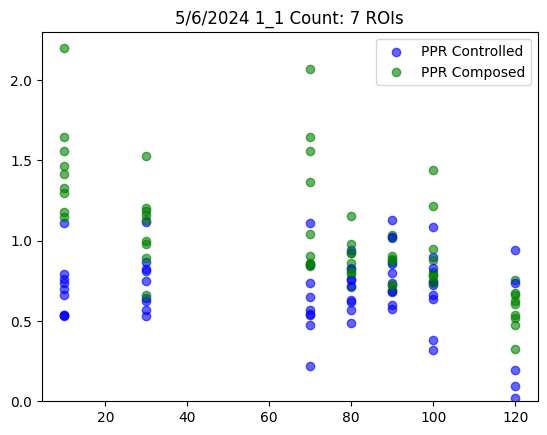

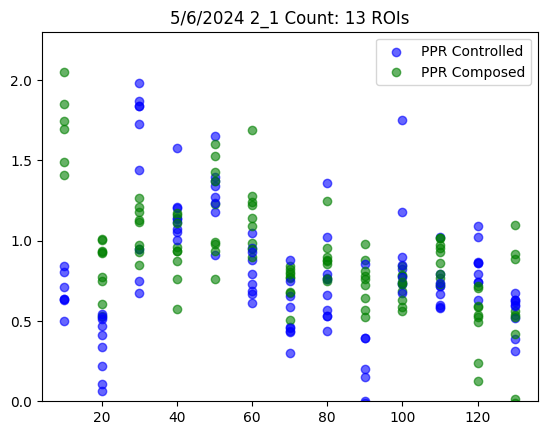

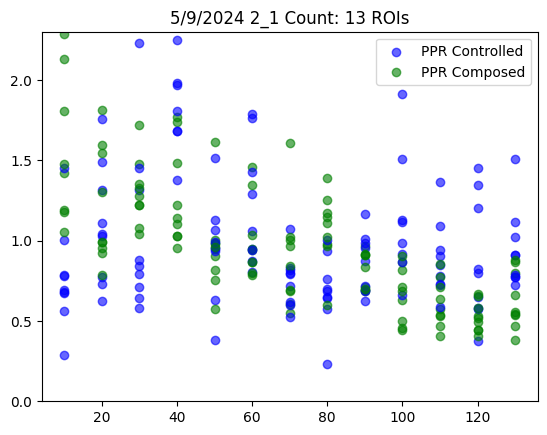

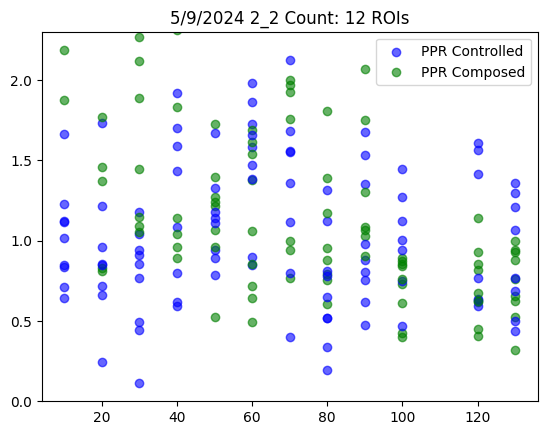

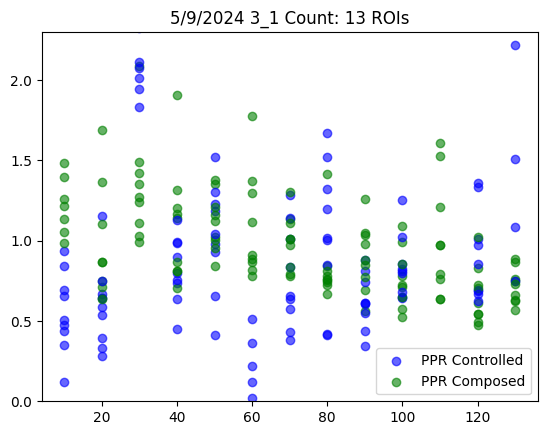

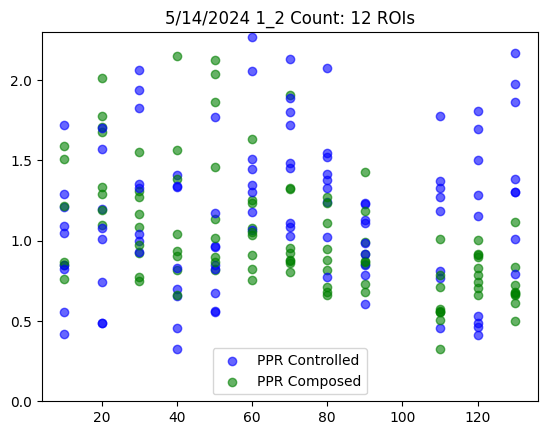

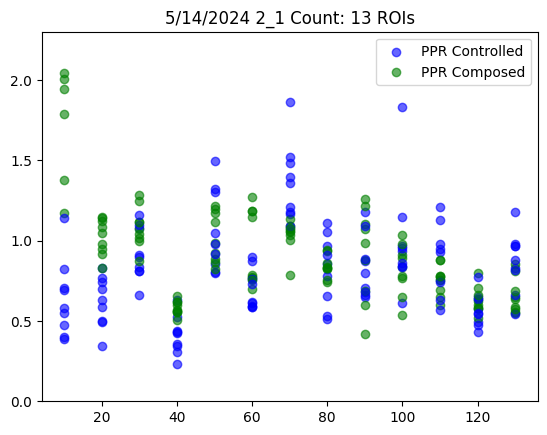

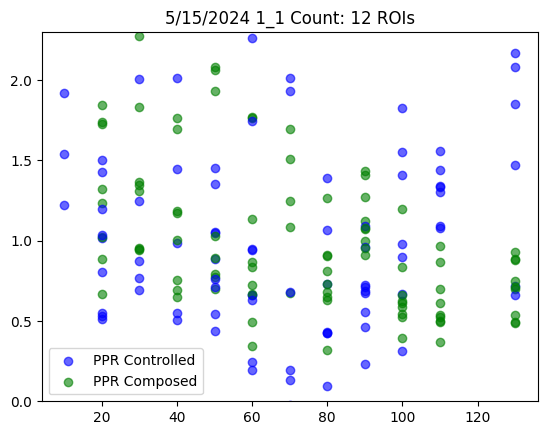

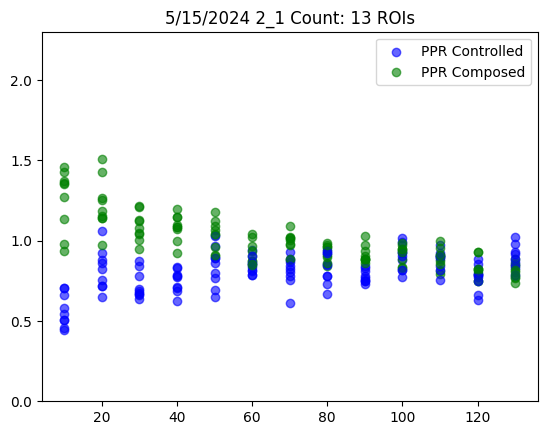

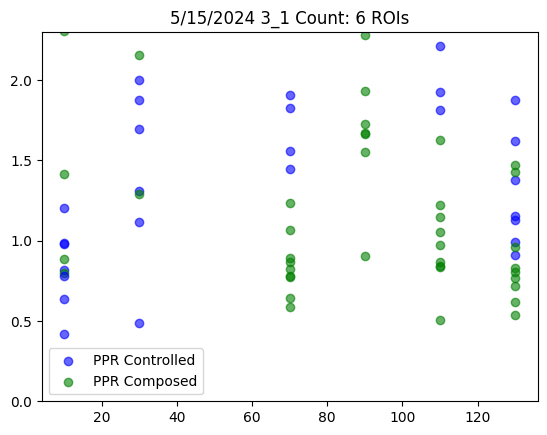

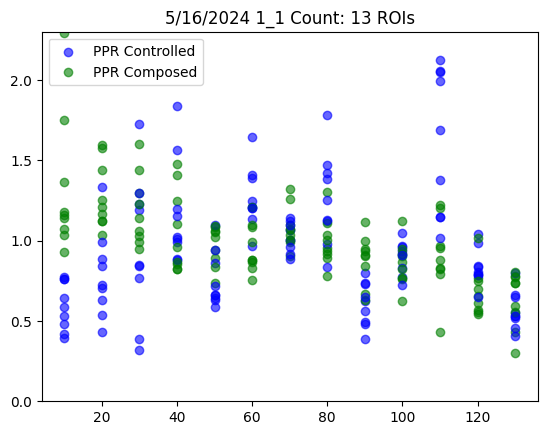

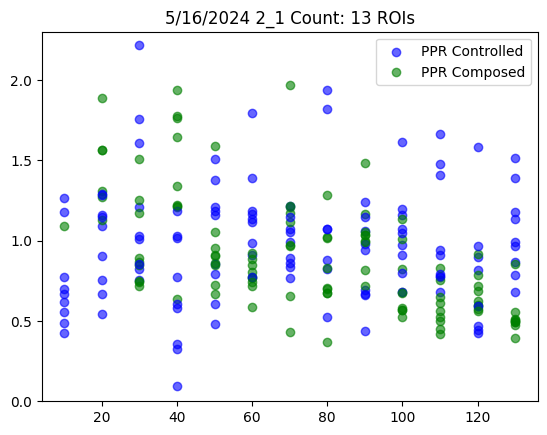

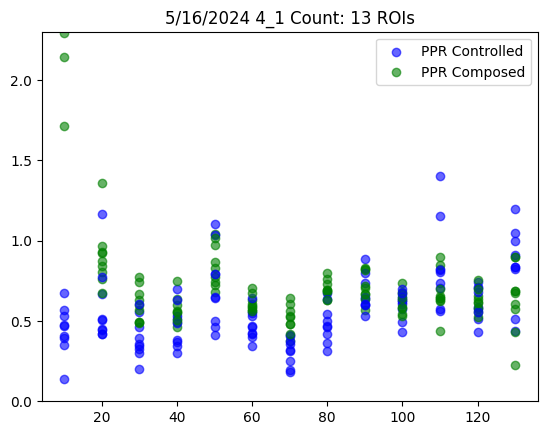

In [26]:
# for each date, slice/loc, and ROI, plot PPR vs IPI
plt.rcParams.update(plt.rcParamsDefault)
for date in df['Date'].unique():
    pfs_date = df[df["Date"] == date]
    for slic_loc in pfs_date['Slice_Loc'].unique():
        pfs_sl = pfs_date[pfs_date["Slice_Loc"] == slic_loc]
        for roi in pfs_sl['ROI'].unique():

            # plot PPR
            pfs_roi = pfs_sl[pfs_sl['ROI'] == roi]
            l1 = plt.scatter(pfs_roi['IPI'], pfs_roi['PPR'], label='PPR Controlled', c = 'b', alpha=0.6)
            

            # plot PPR Composed
            l2 = plt.scatter(pfs_roi['IPI'], pfs_roi['PPR Composed'], label='PPR Composed', c='g', alpha=0.6)
        plt.legend(handles=[l1, l2], labels=['PPR Controlled', 'PPR Composed'])
        plt.title(date + " " + slic_loc + " Count: " + str(len(pfs_roi)) + " ROIs")
        plt.ylim(0, 2.3)
        plt.show()
        '''plt.scatter(pfs_roi['IPI'], pfs_roi['PPL'], c='r')
        plt.title(date + " " + slic_loc + " ROI " + str(roi))
        plt.show()
        plt.scatter(pfs_roi['IPI'], pfs_roi['PPHW'], c='g')
        plt.title(date + " " + slic_loc + " ROI " + str(roi))
        plt.show()'''

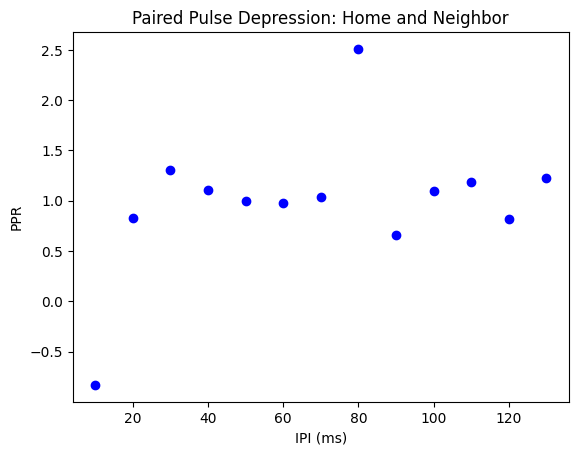

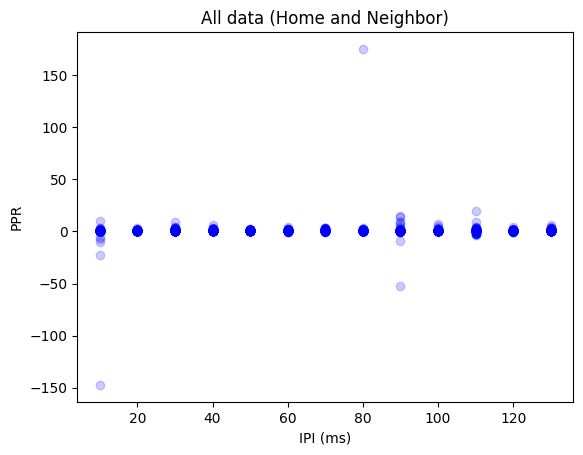

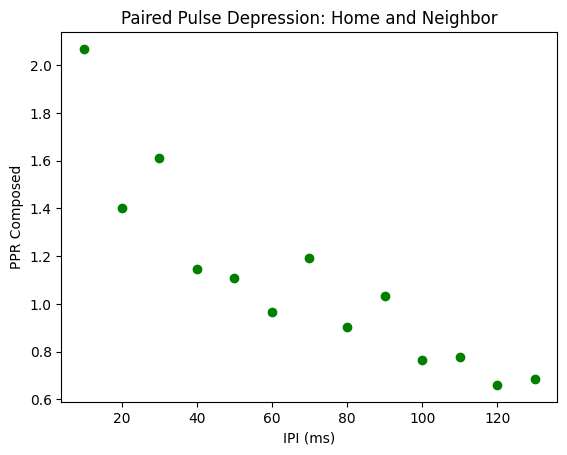

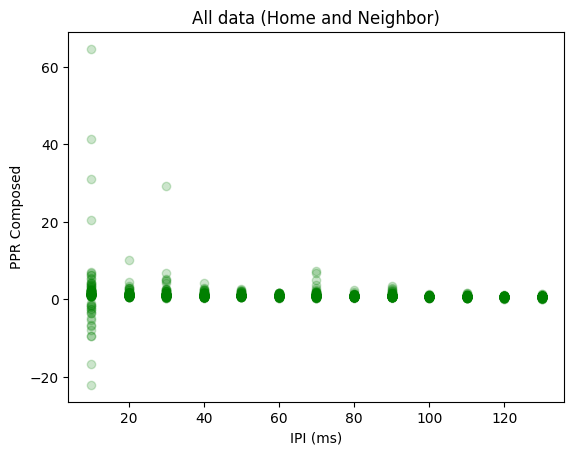

In [18]:
# average grouping by IPI
for pp_type, color in [['PPR', 'b'], ['PPR Composed', 'g']]: #, ['PPL', 'r'], ['PPHW', 'g']]:
    group_by_ipi = df[['IPI', pp_type]].groupby(by=['IPI']).mean()
    group_by_ipi_std = df[['IPI', pp_type]].groupby(by=['IPI']).agg(np.std)
    group_by_ipi.reset_index(inplace=True)
    
    

    # plot average PPR vs IPI
    plt.scatter(group_by_ipi['IPI'], group_by_ipi[pp_type], c=color)
    plt.title("Paired Pulse Depression: Home and Neighbor")
    plt.xlabel("IPI (ms)")
    plt.ylabel(pp_type)
    plt.show()
    plt.scatter(df['IPI'], df[pp_type], alpha=0.2, c=color)
    plt.xlabel("IPI (ms)")
    plt.ylabel(pp_type)
    plt.title("All data (Home and Neighbor)")
    plt.show()

     PPR
IPI     
10    13
20    11
30    13
40    11
50    11
60    11
70    13
80    12
90    13
100   11
110   11
120   11
130   12
i= 0
10
p_val for IPI 20 : 0.8516343924509097
p_val for IPI 30 : 0.9485097013601853
p_val for IPI 40 : 0.8604642185964122
p_val for IPI 50 : 0.8991756785400092
p_val for IPI 60 : 0.8672144157718251
p_val for IPI 70 : 0.9087190275551628
p_val for IPI 80 : 0.8749007898152161
p_val for IPI 90 : 0.8993135617757241
p_val for IPI 100 : 0.8815917174767146
p_val for IPI 110 : 0.8653787916006441
p_val for IPI 120 : 0.7857084612168672
p_val for IPI 130 : 0.9288777463277097
[None, None, None, None, None, None, None, None, None, None, None, None, None]
     PPR
IPI     
10   104
20    88
30   104
40    88
50    88
60    88
70   104
80    96
90   104
100   88
110   88
120   88
130   96
i= 1
110
p_val for IPI 10 : 0.07063794276949542
p_val for IPI 20 : 0.08000079096453812
p_val for IPI 30 : 0.644932040862503
p_val for IPI 40 : 0.3965713175823522
p_val for IPI 50 : 0.

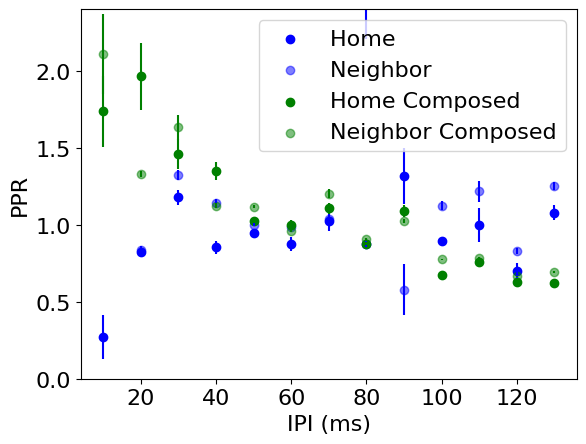

In [19]:
# home barrel or neighboring barrel
plt.rcParams.update({'font.size': 16})

home_barrel_df = df.query('`Home Barrel` == ROI')
neighbor_barrel_df = df.query('`Home Barrel` != ROI')
titles = ['Home Barrel', 'Neighbor Barrel']

for pp_type, color in [['PPR', 'b'], ['PPR Composed', 'g']]: #, ['PPL', 'r'], ['PPHW', 'g']]:
    i = 0
    for barrel_df in [home_barrel_df, neighbor_barrel_df]:
        
        if pp_type in ['PPL', 'PPHW']:
            barrel_df = barrel_df[barrel_df['IPI'] > 20]
        group_by_ipi = barrel_df[['IPI', pp_type]].groupby(by=['IPI']).mean()
        group_by_ipi_std = barrel_df[['IPI', pp_type]].groupby(by=['IPI']).agg(np.std) / np.sqrt(len(barrel_df))
        group_by_ipi.reset_index(inplace=True)

        count_by_ipi = barrel_df[['IPI', pp_type]].groupby(by=['IPI']).count()
        print(count_by_ipi)

        # significance tests against the first IPI
        first_ipi = np.min(group_by_ipi['IPI'])
        pvals = []
        print("i=", i)
        if pp_type == 'PPR' and titles[i] == 'Neighbor Barrel':
            first_ipi = 110
        print(first_ipi)
        
        first_ipi_data = barrel_df[barrel_df['IPI'] == first_ipi][pp_type]
        for ipi in group_by_ipi['IPI']:
            if ipi == first_ipi:
                pvals.append(1)
                continue
            ipi_data = barrel_df[barrel_df['IPI'] == ipi][pp_type]
            
            # one-sided t-test if ipi_data is less than first_ipi_data
            t_stat, p_val = ttest_ind(ipi_data, first_ipi_data, alternative='less', equal_var=False)
            print("p_val for IPI", ipi, ":", p_val)
            pvals.append(p_val)

        def get_sig_level(x):
            if x < 0.001:
                return '***'
            if x < 0.01:
                return '**'
            if x < 0.05:
                return '*'
        significance_levels = [get_sig_level(x) for x in pvals]
        print(significance_levels)
            
        alph = 1.0
        if titles[i] == 'Neighbor Barrel':
            alph = 0.5

        label = titles[i].split(" ")[0] + " "
        if len(pp_type.split(" ")) > 1:
            label += pp_type.split(" ")[1]
        plt.scatter(group_by_ipi['IPI'], group_by_ipi[pp_type], c=color, alpha=alph, label=label)
        plt.errorbar(group_by_ipi['IPI'], group_by_ipi[pp_type], 
                     group_by_ipi_std[pp_type], ls='none', c=color)
        y_label = pp_type
        if pp_type == 'PPL':
            y_label = "Paired-pulse ratio\n of Latency"
        if pp_type == 'PPHW':
            y_label = "Paired-pulse ratio\n of Half-width"
        # plt.title("Paired Pulse Depression in " + titles[i])
        
        # place significance levels on plot
        #for j, txt in enumerate(significance_levels):
        #    plt.annotate(txt, (group_by_ipi['IPI'].iloc[j], min(0.95, group_by_ipi[pp_type].iloc[j] + 0.25)), fontsize=12)

        plt.xlabel("IPI (ms)")
        #plt.xticks([])
        
        plt.ylim([0, 2.4])
        plt.ylabel(y_label)
        
        i += 1
plt.legend()
plt.ylabel("PPR")
plt.show()

In [ ]:
# home barrel or neighboring barrel
plt.rcParams.update({'font.size': 16})

home_barrel_df = df.query('`Home Barrel` == ROI')
neighbor_barrel_df = df.query('`Home Barrel` != ROI')
pvals = []
# significance tests: home versus neighbor
for ipi in group_by_ipi['IPI']:
    
    # one-sided t-test if ipi_data is less than first_ipi_data
    t_stat, p_val = ttest_ind(neighbor_barrel_df[neighbor_barrel_df['IPI'] == ipi]["PPR"],
                              home_barrel_df[home_barrel_df['IPI'] == ipi]["PPR"],  
                                alternative='less', 
                                equal_var=False)
    print("p_val for IPI", ipi, ":", p_val)
    pvals.append(p_val)

def get_sig_level(x):
    if x < 0.001:
        return '***'
    if x < 0.01:
        return '**'
    if x < 0.05:
        return '*'
significance_levels = [get_sig_level(x) for x in pvals]
print(significance_levels)

In [ ]:
# autoPhotoZ to save amplitude arrays for each measure window and 
# baseline correction to create PPR maps
def get_amp_array_filename(subdir, slic_loc_id, ipi, pulse):
    return subdir + "/" + "ampArray_" + slic_loc_id + "_ipi" + str(ipi) + "_p" + str(pulse) + ".dat"

overwrite_amp_arrays = False
select_amp_bkg = False
for subdir in data_map:
    aPhz = AutoPhotoZ(data_dir=subdir)
    if not select_amp_bkg and enable_photoZ_interact:
        aPhz.select_MaxAmp_array()
    print(subdir)
    for slic_id in data_map[subdir]:

        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)

            ipi_file = data_map[subdir][slic_id][loc_id]['shuffle_file']
            with open(ipi_file, 'r') as f:
                lines = f.readlines() 
            ipi_order = [x for x in lines]
            for k in range(len(ipi_order)):
                ipi = ipi_order[k].split("\t")
                ipi = int(ipi[1]) - int(ipi[0])
                ipi_order[k] = ipi

            # open zda files in order
            i_ipi = -1
            for zda_file in data_map[subdir][slic_id][loc_id]['zda_files']:

                i_ipi += 1
                try:
                    ipi = ipi_order[i_ipi]
                except Exception as e:
                    print(e)
                    print("Not enough IPIs for how many recordings we have! Last IPI:", ipi, "Check", subdir)
                print(slic_id, loc_id, "IPI:", ipi, "ms for recording", zda_file.split("/")[-1])
                
                # check if all amp arrays are already saved for this recording/IPI
                all_saved = True
                for i_pulse in [1, 2]:
                    amp_array_filename = get_amp_array_filename(subdir, slic_loc_id, ipi, i_pulse)
                    if not os.path.exists(amp_array_filename):
                        print("Missing", amp_array_filename)
                        all_saved = False
                        break
                if overwrite_amp_arrays:
                    all_saved = False

                if enable_photoZ_interact and not all_saved:
                    aPhz.open_zda_file(zda_file)

                    # set polynomial skip window to eclipse BOTH pulses
                    end_skip = 550
                    first_pulse_start = 356 - (ipi * 2)
                    skip_width = end_skip - first_pulse_start
                    aPhz.set_polynomial_skip_window(first_pulse_start,
                                                            skip_width=skip_width)
                for i_pulse in [1, 2]:
                    amp_array_filename = get_amp_array_filename(subdir, slic_loc_id, ipi, i_pulse)
                    if not os.path.exists(amp_array_filename) or overwrite_amp_arrays:
                        if enable_photoZ_interact and not all_saved:
                            #measure_window_start = 96 + (i_pulse - 1) * ipi * 2
                            measure_window_start = 356
                            if i_pulse == 1:
                                measure_window_start -= ipi * 2
                            aPhz.set_measure_window(measure_window_start, None)


                        # take Amplitude array from PhotoZ
                        if enable_photoZ_interact and not all_saved:
                            aPhz.save_background(filename=amp_array_filename)
                    else:
                        if not all_saved:
                            time.sleep(5)

                    if ipi not in data_map[subdir][slic_id][loc_id]:
                        data_map[subdir][slic_id][loc_id][ipi] = {}
                    if i_pulse not in data_map[subdir][slic_id][loc_id][ipi]:
                        data_map[subdir][slic_id][loc_id][ipi][i_pulse] = {}
                    data_map[subdir][slic_id][loc_id][ipi][i_pulse]['amp_array'] = amp_array_filename
                    
            if i_ipi < len(ipi_order) - 1:
                print("Not enough recordings for how many IPIs we have! Last IPI:", ipi, "Check", subdir)
                        

In [ ]:
# use amp arrays of both pulses to create PPR maps of different IPIs of the recordings 
def read_dat_arr_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['Index',  'Value'])
    data_arr = np.array(data_arr['Value']).reshape((80, 80))
    return data_arr

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

#x, y inputs can be lists or 1D numpy arrays

def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

area_by_ipi = {'ipi': [], 'area': []}
ppr_hist = []
pphw_hist = []
ppl_hist = []
amp_cutoff = 0
# load in amp array files into dataframe for each IPI
for subdir in data_map:
    
    # extract date from subdir so we can look up metadata from master_df
    date = subdir.split("/")[-1].split('-')
    date = [int(x) for x in date]
    date[-1] += 2000
    date = "/".join([str(x) for x in date])
    metadata_date = master_df[master_df['Date'] == date]
    
    for slic_id in data_map[subdir]:
        for loc_id in data_map[subdir][slic_id]:
            if type(loc_id) == str:
                continue
            slic_loc_id = str(slic_id) + "_" + str(loc_id)
            metadata = metadata_date[metadata_date['Slice_Loc'] == slic_loc_id]
            medial_dir = metadata['Medial Dir'].item()
            stim_layer = metadata['Stim Layer'].item()
            caudal_rostral = metadata['Caudal/Rostral'].item()
            home_barrel = int(metadata['Home Barrel'].item())

            for ipi in data_map[subdir][slic_id][loc_id]:

                if type(ipi) == str:
                    continue
                
                # load amp files as numpy arrays using np.loadtxt
                amp_arr1 = get_amp_array_filename(subdir, slic_loc_id, ipi, 1)
                amp_arr2 = get_amp_array_filename(subdir, slic_loc_id, ipi, 2)
                amp_arr1 = read_dat_arr_file(amp_arr1)
                amp_arr2 = read_dat_arr_file(amp_arr2)
                ppr_map_tmp = amp_arr2 / amp_arr1

                area1 = np.sum(amp_arr1 > amp_cutoff)
                area2 = np.sum(amp_arr2 > amp_cutoff)
                if area1 > 0:
                    area_ratio = area2 / area1
                    area_by_ipi['area'].append(area_ratio)
                    area_by_ipi['ipi'].append(ipi)

                ppr_map_tmp[amp_arr1 < amp_cutoff] = 0

                # load barrel ROIs from .dat file
                roi_file = data_map[subdir][slic_id]['roi_file']
                barrel_rois = ROIFileReader(roi_file).get_roi_list()

                # convert from diode to pixel
                barrel_rois = [LaminarROI(roi, input_diode_numbers=True).get_points()
                            for roi in barrel_rois]
                ppr_hist = [[] for _ in range(len(barrel_rois))]

                # transfer PPR values to ppr_map if they are in the ROIs
                ppr_map = np.zeros((80, 80))
                for i in range(80):
                    for j in range(80):
                        for k, roi in enumerate(barrel_rois):
                            for px in roi:
                                if i == px[1] and j == px[0]:
                                    ppr_map[i, j] = ppr_map_tmp[i, j]
                                    break


                if True: #np.sum(ppr_map) > 0:
                    fig, axes = plt.subplots(1, 3)
                    axes[0].imshow(ppr_map, cmap='viridis')
                    axes[1].imshow(amp_arr1, cmap='viridis')
                    axes[2].imshow(amp_arr2, cmap='viridis')
                    plt.show()
                    #print(np.max(ppr_map), np.min(ppr_map))'''
                


                # build histogram of PPR values for pixels above cutoff
                for i in range(amp_arr1.shape[0]):
                    for j in range(amp_arr1.shape[1]):
                        if amp_arr1[i, j] > amp_cutoff and 0 < ppr_map[i, j] < 2: # and amp_arr2[i, j] != amp_arr1[i, j]:
                            
                            # find which barrel ROI this pixel is in
                            for k, roi in enumerate(barrel_rois):
                                for px in roi:
                                    if i == px[1] and j == px[0]:
                                        ppr_hist[k].append(ppr_map[i, j])
                                        break
                print([len(x) for x in ppr_hist])
                colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
                for i_h, ppr_h in enumerate(ppr_hist):
                    if len(ppr_h) < 10:
                        continue

                    # plot histogram of PPR values
                    y,x,_=plt.hist(ppr_h, bins=100, color=colors[i_h], alpha=0.3)
                    plt.title("Histogram of PPR values")


                    x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

                    expected = (0.7, .02, 25, 0.8, .02, 15)
                    try:
                        params, cov = curve_fit(bimodal, x, y, expected)
                    except:
                        continue
                    sigma=np.sqrt(np.diag(cov))
                    x_fit = np.linspace(x.min(), x.max(), 500)
                    #plot combined...
                    plt.plot(x_fit, bimodal(x_fit, *params), color=colors[i_h], lw=3)
                    #...and individual Gauss curves
                    '''plt.plot(x_fit, gauss(x_fit, *params[:3]), 
                            color='tab:orange', lw=3, ls="--", label='mean PPR: 0.74 ± 0.01' )
                    plt.plot(x_fit, gauss(x_fit, *params[3:]), 
                            color='tab:green', lw=3, ls=":", label='mean PPR: 0.82 ± 0.07')'''
                    #and the original data points if no histogram has been created before
                    #plt.scatter(x, y, marker="X", color="black", label="original data")
                    #plt.legend(loc = 'upper left')
                    #plt.ylim(0, 17)
                    #plt.xlim(0.2, 1.2)
                    print(pd.DataFrame(data={'params': params, 'sigma': sigma}, index=bimodal.__code__.co_varnames[1:]))
                plt.show() 

